In [1]:
import pandas as pd
import numpy as np

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

import yaml

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

import spacy

from multiprocessing import Pool, cpu_count
 

RAND = 42

In [2]:
def get_bins_target(df: pd.DataFrame, target_name: str) -> None:
    # нормирование на размер датасета
    norm_target = (df[target_name].value_counts(
        normalize=True).mul(100).rename('percent').reset_index())

    plt.figure(figsize=(15, 7))
    ax = sns.barplot(x='index', y='percent', data=norm_target)

    # Вывод значений над графиками - annotate()
    # В цикле смотрим каждый столбец графика и на нем отмечаем значения
    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(
            percentage,  # текст
            # координата xy
            (p.get_x() + p.get_width() / 2., p.get_height()),
            # центрирование
            ha='center',
            va='center',
            xytext=(0, 10),
            # точка смещения относительно координаты
            textcoords='offset points',
            fontsize=14)

    plt.title(target_name, fontsize=20)
    plt.xlabel(target_name, fontsize=14)
    plt.ylabel('Проценты', fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [3]:
def barplot_group(col_main: str, col_group: str, title: str = None) -> None:
    """
    Построение barplot с нормированными данными с выводом значений на графике
    """

    plt.figure(figsize=(15, 6))

    data = (df.groupby([col_group])[col_main]
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values(col_group))

    ax = sns.barplot(x=col_main, y="percentage",
                     hue=col_group, data=data, palette='rocket')

    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(percentage,  # текст
                    (p.get_x() + p.get_width() / 2.,
                     p.get_height()),  # координата xy
                    ha='center',  # центрирование
                    va='center',
                    xytext=(0, 7),
                    textcoords='offset points',  # точка смещения относительно координаты
                    fontsize=12)

    plt.title(title, fontsize=16)
    plt.ylabel('Percentage', fontsize=14)
    plt.xlabel(col_main, fontsize=14)
    plt.show()

In [4]:
def change_id(df_t: pd.DataFrame, columns: list) -> None:
    for col in columns:
        df_t[col] = df_t[col].apply(lambda x: x.split('_')[1])

In [5]:
config_path = "../config/params.yaml"
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

preproc = config["preprocessing"]

# Описание задачи

Данные предоставлены оператором электронных торгов.  

Задача состоит в разработке **рекомендательного сервиса** для поставщиков.  

В данном случае рекомендательный сервис необходим для более активного участия поставщиков в торгах за счет того, что им предлагаются более подходящие для них заказы.  

Для разработки рекомендательного алгоритма имеется информация о предыдущих заказах и участии поставщиков в них. Также известно, какой из поставщиков победил в торгах.  

Поля в датасете purchases:  
 - purchase – Уникальный идентификатор закупки  
 - region_code – Регион поставки  
 - min_publish_date – Дата публикации закупки (дата, с которой закупку смогли видеть поставщики и присылать свои предложения)  
 - purchase_name – Название закупки  
 - forsmallbiz – Если да, то большие компании не могут предлагать свое участие в этой закупке  
 - price – Цена за закупку, предлагаемая заказчиком  
 - customer – Уникальный идентификатор заказчика  
 - okpd2_code – Код стандартизации товара в соответствии со справочником ОКПД2, обрезанный до 3 числа  
 - okpd2_names – Названия ОКПД2, в этом поле может быть записано несколько названий ОКПД2 через разделитель “ || “, так как поле okpd2_code это обобщенный код.
 - Item_descriptions – Описания товаров, записанные через разделитель “ || “.  
 
Поля в датасете suppliers:  
 - purchase – Уникальный идентификатор закупки  
 - supplier – Уникальный идентификатор поставщика  
 - is_winner – Выиграл ли этот поставщик в этой закупке

In [6]:
df_pur = pd.read_csv("../data/small_purchases.csv", sep=";")
df_sup = pd.read_csv("../data/small_suppliers.csv", sep=";")

In [7]:
df_pur[:5]

,purchase,region_code,min_publish_date,purchase_name,forsmallbiz,price,customer,okpd2_code,okpd2_names,item_descriptions
0,Закупка_1,2,2021-11-24,Услуги по проведению финансового аудита,f,190000.00,Заказчик_1,69.2,Услуги по проведению финансового аудита,Услуги по проведению финансового аудита
1,Закупка_2,2,2022-11-18,Услуги по проведению финансового аудита,f,271000.00,Заказчик_1,69.2,Услуги по проведению финансового аудита,Услуги по проведению финансового аудита
2,Закупка_3,2,2021-02-02,оказание информационных услуг с использованием...,t,290000.00,Заказчик_2,58.2,Услуги по предоставлению лицензий на право исп...,оказание информационных услуг с использованием...
3,Закупка_4,2,2021-02-02,"Услуги по дизайнерскому оформлению, изготовлен...",t,190809.00,Заказчик_2,18.1,"Услуги печатные прочие, не включенные в другие...","оказание услуг по дизайнерскому оформлению, из..."
4,Закупка_5,2,2021-02-11,поставка сувенирной продукции для проведения м...,t,278263.34,Заказчик_2,26.2,Клавиатуры || Комплектующие и запасные части д...,Комплект беспроводной клавиатуры и беспроводно...


In [8]:
df_sup[:5]

,purchase,supplier,is_winner
0,Закупка_3,Поставщик_1,1
1,Закупка_14,Поставщик_2,1
2,Закупка_14,Поставщик_3,0
3,Закупка_5,Поставщик_4,0
4,Закупка_5,Поставщик_2,0


In [9]:
df = pd.merge(df_pur, df_sup, on='purchase')
df[:5]

,purchase,region_code,min_publish_date,purchase_name,forsmallbiz,price,customer,okpd2_code,okpd2_names,item_descriptions,supplier,is_winner
0,Закупка_1,2,2021-11-24,Услуги по проведению финансового аудита,f,190000.0,Заказчик_1,69.2,Услуги по проведению финансового аудита,Услуги по проведению финансового аудита,Поставщик_104753,1
1,Закупка_1,2,2021-11-24,Услуги по проведению финансового аудита,f,190000.0,Заказчик_1,69.2,Услуги по проведению финансового аудита,Услуги по проведению финансового аудита,Поставщик_104929,0
2,Закупка_1,2,2021-11-24,Услуги по проведению финансового аудита,f,190000.0,Заказчик_1,69.2,Услуги по проведению финансового аудита,Услуги по проведению финансового аудита,Поставщик_37544,0
3,Закупка_2,2,2022-11-18,Услуги по проведению финансового аудита,f,271000.0,Заказчик_1,69.2,Услуги по проведению финансового аудита,Услуги по проведению финансового аудита,Поставщик_104753,1
4,Закупка_2,2,2022-11-18,Услуги по проведению финансового аудита,f,271000.0,Заказчик_1,69.2,Услуги по проведению финансового аудита,Услуги по проведению финансового аудита,Поставщик_11259,0


In [10]:
change_id(df, ["purchase", "customer", "supplier"])
df['forsmallbiz'].replace({'t': 1, 'f': 0}, inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958129 entries, 0 to 958128
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   purchase           958129 non-null  object 
 1   region_code        958129 non-null  int64  
 2   min_publish_date   958129 non-null  object 
 3   purchase_name      958044 non-null  object 
 4   forsmallbiz        958129 non-null  int64  
 5   price              958129 non-null  float64
 6   customer           958129 non-null  object 
 7   okpd2_code         958129 non-null  object 
 8   okpd2_names        958129 non-null  object 
 9   item_descriptions  957564 non-null  object 
 10  supplier           958129 non-null  object 
 11  is_winner          958129 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 95.0+ MB


In [12]:
df.shape

(958129, 12)

In [13]:
df = df.astype(preproc['change_type_columns'])

In [14]:
df.describe().iloc[1:, :]

,forsmallbiz,price,is_winner
mean,0.709252,5.400899e+06,0.346879
std,0.454108,1.448377e+08,0.475977
min,0.000000,1.700000e-01,0.000000
25%,0.000000,1.661750e+05,0.000000
50%,1.000000,5.992800e+05,0.000000
75%,1.000000,2.038950e+06,1.000000
max,1.000000,5.703527e+10,1.000000


In [15]:
df.describe(include=object)

,purchase_name,item_descriptions
count,958044,957564
unique,236046,138985
top,Поставка канцелярских товаров,Бумага для офисной техники белая
freq,5239,10213


In [16]:
df.describe(include='category')

,purchase,region_code,customer,okpd2_code,okpd2_names,supplier
count,958129,958129,958129,958129,958129,958129
unique,328257,86,11680,244,21493,100732
top,424615,77,9582,drug,Лекарства,694
freq,80,309840,17809,99192,99192,4217


In [17]:
df.isna().sum()/df.shape[0] * 100

purchase             0.000000
region_code          0.000000
min_publish_date     0.000000
purchase_name        0.008871
forsmallbiz          0.000000
price                0.000000
customer             0.000000
okpd2_code           0.000000
okpd2_names          0.000000
item_descriptions    0.058969
supplier             0.000000
is_winner            0.000000
dtype: float64

In [18]:
df[df['item_descriptions'].isna()].describe(include=['category', object])

,purchase,region_code,purchase_name,customer,okpd2_code,okpd2_names,item_descriptions,supplier
count,565,565,565,565,565,565,0,565
unique,226,17,203,54,1,1,0,200
top,531605,33,Поставка лекарственного препарата для медицинс...,7549,drug,Лекарства,NaN,694
freq,13,111,13,85,565,565,NaN,30


In [19]:
#заполним пропуски в поле item_descriptions значениями из колонки purchase_name
df['item_descriptions'].fillna(df['purchase_name'], inplace=True)

In [20]:
df[df['purchase_name'].isna()].describe(include=['category', object])

,purchase,region_code,purchase_name,customer,okpd2_code,okpd2_names,item_descriptions,supplier
count,85,85,0,85,85,85,85,85
unique,42,9,0,15,14,31,31,43
top,482224,5,NaN,390,31.0,Бензин автомобильный АИ-92 экологического клас...,Шкаф деревянный для документов,2424
freq,3,44,NaN,20,34,6,6,10


In [21]:
#заполним пропуски в поле purchase_name значениями из колонки okpd2_names
df['purchase_name'].fillna(df['okpd2_names'], inplace=True)

In [22]:
df.isna().sum()

purchase             0
region_code          0
min_publish_date     0
purchase_name        0
forsmallbiz          0
price                0
customer             0
okpd2_code           0
okpd2_names          0
item_descriptions    0
supplier             0
is_winner            0
dtype: int64

In [23]:
df[:5]

,purchase,region_code,min_publish_date,purchase_name,forsmallbiz,price,customer,okpd2_code,okpd2_names,item_descriptions,supplier,is_winner
0,1,2,2021-11-24,Услуги по проведению финансового аудита,0,190000.0,1,69.2,Услуги по проведению финансового аудита,Услуги по проведению финансового аудита,104753,1
1,1,2,2021-11-24,Услуги по проведению финансового аудита,0,190000.0,1,69.2,Услуги по проведению финансового аудита,Услуги по проведению финансового аудита,104929,0
2,1,2,2021-11-24,Услуги по проведению финансового аудита,0,190000.0,1,69.2,Услуги по проведению финансового аудита,Услуги по проведению финансового аудита,37544,0
3,2,2,2022-11-18,Услуги по проведению финансового аудита,0,271000.0,1,69.2,Услуги по проведению финансового аудита,Услуги по проведению финансового аудита,104753,1
4,2,2,2022-11-18,Услуги по проведению финансового аудита,0,271000.0,1,69.2,Услуги по проведению финансового аудита,Услуги по проведению финансового аудита,11259,0


In [24]:
df['reg_code_small'] = df['okpd2_code'].astype('str') + '_' \
                + df['region_code'].astype('str') + '_' \
                + df['forsmallbiz'].astype('str')

In [25]:
df = df.sort_values(['supplier', 'min_publish_date'])

In [26]:
df[:5]

,purchase,region_code,min_publish_date,purchase_name,forsmallbiz,price,customer,okpd2_code,okpd2_names,item_descriptions,supplier,is_winner,reg_code_small
8,3,2,2021-02-02,оказание информационных услуг с использованием...,1,290000.00,2,58.2,Услуги по предоставлению лицензий на право исп...,оказание информационных услуг с использованием...,1,1,58.2_2_1
8151,2834,2,2021-02-02,Оказание информационных услуг с использованием...,1,105000.00,218,62.0,Оригиналы программного обеспечения прочие,Оказание информационных услуг с использованием...,1,1,62.0_2_1
457484,154949,2,2021-02-16,Оказание услуг по сопровождению (обновлению) с...,1,98967.50,11235,63.9,Услуги информационные автоматизированные компь...,Информационные услуги с использованием экземпл...,1,1,63.9_2_1
437783,147950,2,2021-03-10,Оказание информационных услуг с использованием...,0,77460.03,11061,62.0,Услуги по технической поддержке в области инфо...,Оказание информационных услуг с использованием...,1,1,62.0_2_0
488119,165990,2,2021-03-26,Обновление с использованием экземпляров Систем...,0,138000.00,11558,62.0,Услуги по технической поддержке информационных...,услуги по обновлению с использованием экземпля...,1,1,62.0_2_0


In [27]:
df_mod = df.copy()

In [28]:
df_mod = df_mod.drop(columns=['region_code', 'forsmallbiz', 'okpd2_code'])

In [29]:
df_mod = df_mod.sort_values(['supplier', 'min_publish_date'])

In [30]:
df_mod = df_mod.set_index(['supplier', 'purchase'])

In [31]:
df_mod[:10]

min_publish_date  \
supplier purchase                    
1        3              2021-02-02   
         2834           2021-02-02   
         154949         2021-02-16   
         147950         2021-03-10   
         165990         2021-03-26   
         1991           2021-11-22   
         1049           2021-11-29   
         535051         2021-11-29   
         2435           2021-12-06   
         154436         2021-12-22   

                                                       purchase_name  \
supplier purchase                                                      
1        3         оказание информационных услуг с использованием...   
         2834      Оказание информационных услуг с использованием...   
         154949    Оказание услуг по сопровождению (обновлению) с...   
         147950    Оказание информационных услуг с использованием...   
         165990    Обновление с использованием экземпляров Систем...   
         1991      Оказание  услуг по адаптации  и сопровождению ...   
         1049      Оказание услуг  по адаптации и сопровождению э...   
         535051    Оказание услуг по адаптации и сопровождению эк...   
         2435      Оказание услуг по адаптации и сопровождению эк...   
         154436    Оказание услуг по адаптации и сопровождению эк...   

                       price customer  \
supplier purchase                       
1        3         290000.00        2   
         2834      105000.00      218   
         154949     98967.50    11235   
         147950     77460.03    11061   
         165990    138000.00    11558   
         1991      354240.00      169   
         1049      167960.04       70   
         535051     53280.00    11078   
         2435      324360.00      201   
         154436    296342.64    11156   

                                                         okpd2_names  \
supplier purchase                                                      
1        3         Услуги по предоставлению лицензий на право исп...   
         2834              Оригиналы программного обеспечения прочие   
         154949    Услуги информационные автоматизированные компь...   
         147950    Услуги по технической поддержке в области инфо...   
         165990    Услуги по технической поддержке информационных...   
         1991            Услуги по сопровождению компьютерных систем   
         1049      Услуги по предоставлению лицензий на право исп...   
         535051          Услуги по сопровождению компьютерных систем   
         2435      Услуги по технической поддержке информационных...   
         154436                           Услуги по обработке данных   

                                                   item_descriptions  \
supplier purchase                                                      
1        3         оказание информационных услуг с использованием...   
         2834      Оказание информационных услуг с использованием...   
         154949    Информационные услуги с использованием экземпл...   
         147950    Оказание информационных услуг с использованием...   
         165990    услуги по обновлению с использованием экземпля...   
         1991      Оказание услуг по адаптации и сопровождению эк...   
         1049      Оказание услуг по адаптации и сопровождению эк...   
         535051    Оказание услуг по адаптации и сопровождению эк...   
         2435      Услуги по технической поддержке информационных...   
         154436    Услуги по адаптации и сопровождению экземпляро...   

                   is_winner reg_code_small  
supplier purchase                            
1        3                 1       58.2_2_1  
         2834              1       62.0_2_1  
         154949            1       63.9_2_1  
         147950            1       62.0_2_0  
         165990            1       62.0_2_0  
         1991              1       62.0_2_1  
         1049              1       58.2_2_1  
         535051            1       62.0_2_1  
         2435

**Выводы**  
- 

- Максимальное значение цены тендера равно 5703527000, а минимальное - 0.17. Можно предположить, что среди такого большого диапазона значений есть свои ценовые сегменты.   
- Количество уникальных значений признака purchase_name больше, чем уникальных значений item_descriptions. Это может говорить о том, что данные из признака item_descriptions дублируются в purchase_name, когда нет информации, предназначеной специально для purchase_name.  
- Признак is_winner, содержащий информацию о результатах торгов для каждого поставщика в соответствующей закупке, может быть эффективно использован в рекомендательной системе, если при рекомендации вариантов для поставщиков будет учитываться то, с какой вероятностью они победят в выбранных торгах.  
- Признаки region_code, forsmallbiz и okpd2_code могут служить фильтром в рекомендательной системе для некоторых поставщиков, так как переход на другие категории даже по схожими объектам может стать проблематичным.
- Признак min_publish_date может быть полезен для определения самых релевантных рекомендаций для поставщиков, у которых большое количество участий в торгах.

# Гипотезы

- Среди поставщиков можно выделить ценовые сегменты  
- У поставщиков высокая специализация по okpd2  
- Поставщики с большим количеством участий в закупках чаще выигравают  
- Поставщики, которые уже участвовали в закупках с конкретным покупателем, чаще побеждают в последующих закупках с этим покупателем  
- В закупках с большей ценой участвует больше поставщиков, из-за чего шансы победить в них для конкретного поставщика снижаются  
- Поставщики, которые специализируются на конкретных категориях okpd2, чаще побеждают в закупках  
- В закупках, у которых нет ограничения на размер компании-участника, больше участников, из-за чего шансы победить в них для конкретного поставщика снижаются  
- Сезонность влияет на участие поставщиков в закупках  
- Сезонность влияет на количество закупок на рынке  
- Сезонность влияет на категорий okpd2 закупок

## Гипотеза 1  
Среди поставщиков можно выделить ценовые сегменты

In [32]:
#сформируем датасет со средней ценой закупки у поставщика и стандартным отклонением этой цены
df_price = df.groupby('supplier')['price'].mean().to_frame(name='price_mean')
df_price['price_std'] = df.groupby('supplier')['price'].std()

In [33]:
#стандартизируем данные и удалим выбросы для того, чтобы оценить возможность выделения кластеров на плоскости
ss = StandardScaler()
df_price = ss.fit_transform(df_price)

#удаление выбросов делаем достаточно грязно, так как нам нужно оценить само наличие кластеров
df_price = df_price[(df_price[:, 0] < 3) & (df_price[:, 1] < 3)]

In [34]:
df_price.shape

(66045, 2)

<Axes: >

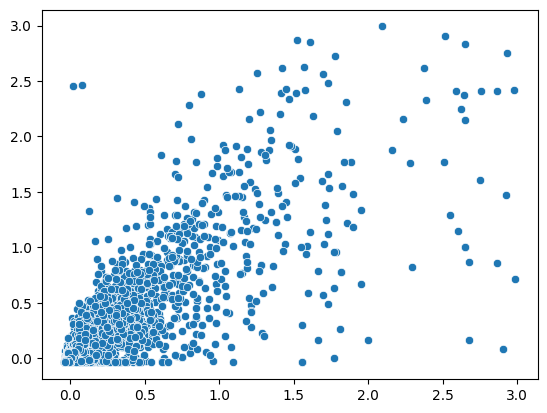

In [35]:
sns.scatterplot(x=df_price[:, 0], y=df_price[:, 1])

Из графика стандартизованных и очищенных от выбросов данных, где по x -  средняя цена закупки, а по y - стандартное отклонение цен закупок поставщиков, показывает, что по только на основания данных признаков выделить кластеры поставщиков нельзя 

## Гипотеза 2

У поставщиков высокая специализация по okpd2

In [36]:
df['okpd2_code'].nunique()

244

In [37]:
n_unique_okpd2 = df.groupby('supplier')['okpd2_code'].nunique()

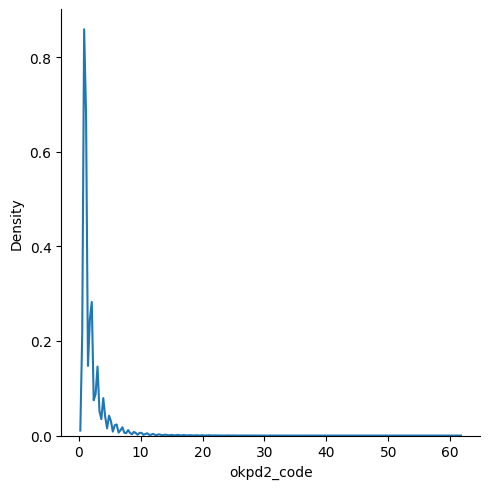

In [38]:
sns.displot(x=n_unique_okpd2, kind='kde')

Из графика видно, что количество уникальных значений okpd2 внутри большинства поставщиков ниже 10, что значительно меньше, чем количество категорий okpd2 всего. 

# Гипотеза 3

Поставщики с большим количеством участий в закупках чаще выигравают. 

In [57]:
df_rn = pd.DataFrame(df.groupby('supplier').size(), columns=['size'])
df_rn['win_share'] = df[df.is_winner == 1].groupby('supplier').size() / df_rn['size'] * 100

In [58]:
df_rn[:5]

,size,win_share
supplier,,
1,21,100.000000
10,7,42.857143
100,6,66.666667
1000,3,0.000000
10000,10,30.000000


In [61]:
q1 = df_rn['size'].quantile(0.25)
q3 = df_rn['size'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# фильтрация выбросов
df_filtered = df_rn[(df_rn['size'] > lower_bound) & (df_rn['size'] < upper_bound)]

In [62]:
df_filtered[:5]

,size,win_share
supplier,,
10,7,42.857143
100,6,66.666667
1000,3,0.000000
10000,10,30.000000
100000,3,33.333333


In [67]:
df_filtered.shape

(88684, 2)

In [73]:
df_filtered.

,size,win_share
count,88684.000000,88684.000000
mean,3.452528,35.017606
std,3.302707,40.200740
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,16.666667
75%,5.000000,66.666667
max,15.000000,100.000000


<Axes: xlabel='size', ylabel='win_share'>

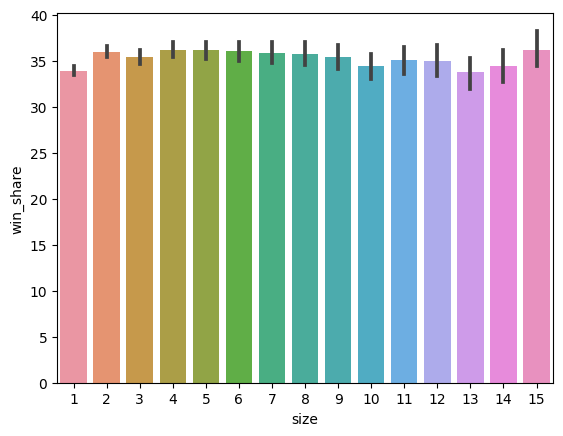

In [75]:
sns.barplot(x=df_filtered['size'], y=df_filtered.win_share)

In [90]:
nlp = spacy.load("ru_core_news_sm")

def lemmatize_text(text: str):
    # Создаем объект Doc для строки, который проходит через обработчики языка
    doc = nlp(text)

    return [_.lemma_ for _ in doc if _.pos_ in {'ADJ', 'NOUN', 'PROPN'}]

def lemmatize_texts(texts):
    with Pool(processes=cpu_count()-1) as pool:
        lemmatized_texts = pool.map(lemmatize_text, texts)
    return lemmatized_texts

In [93]:
df_mod['token_name'] = lemmatize_texts(df_mod['purchase_name'])

In [95]:
df_mod['token_okpd'] = lemmatize_texts(df_mod['okpd2_names'])
df_mod['token_description'] = lemmatize_texts(df_mod['item_descriptions'])

In [96]:
df_mod[:5]

min_publish_date  \
supplier purchase                    
1        3              2021-02-02   
         2834           2021-02-02   
         154949         2021-02-16   
         147950         2021-03-10   
         165990         2021-03-26   

                                                       purchase_name  \
supplier purchase                                                      
1        3         оказание информационных услуг с использованием...   
         2834      Оказание информационных услуг с использованием...   
         154949    Оказание услуг по сопровождению (обновлению) с...   
         147950    Оказание информационных услуг с использованием...   
         165990    Обновление с использованием экземпляров Систем...   

                       price customer  \
supplier purchase                       
1        3         290000.00        2   
         2834      105000.00      218   
         154949     98967.50    11235   
         147950     77460.03    11061   
         165990    138000.00    11558   

                                                         okpd2_names  \
supplier purchase                                                      
1        3         Услуги по предоставлению лицензий на право исп...   
         2834              Оригиналы программного обеспечения прочие   
         154949    Услуги информационные автоматизированные компь...   
         147950    Услуги по технической поддержке в области инфо...   
         165990    Услуги по технической поддержке информационных...   

                                                   item_descriptions  \
supplier purchase                                                      
1        3         оказание информационных услуг с использованием...   
         2834      Оказание информационных услуг с использованием...   
         154949    Информационные услуги с использованием экземпл...   
         147950    Оказание информационных услуг с использованием...   
         165990    услуги по обновлению с использованием экземпля...   

                   is_winner reg_code_small  \
supplier purchase                             
1        3                 1       58.2_2_1   
         2834              1       62.0_2_1   
         154949            1       63.9_2_1   
         147950            1       62.0_2_0   
         165990            1       62.0_2_0   

                                                          token_name  \
supplier purchase                                                      
1        3         [оказание, информационный, услуга, использован...   
         2834      [оказание, информационный, услуга, использован...   
         154949    [оказание, услуга, сопровождение, обновление, ...   
         147950    [оказание, информационный, услуга, использован...   
         165990    [обновление, использование, экземпляр, систем,...   

                                                          token_okpd  \
supplier purchase                                                      
1        3         [услуга, предоставление, лицензия, право, комп...   
         2834           [оригинал, программный, обеспечение, прочие]   
         154949    [услуга, информационный, автоматизированный, к...   
         147950    [услуга, технический, поддержка, область, инфо...   
         165990    [услуга, технический, поддержка, информационны...   

                                                   token_description  
supplier purchase                                                     
1        3         [оказание, информационный, услуга, использован...  
         2834      [оказание, информационный, услуга, использован...  
         154949    [информационный, услуга, использование, экземп...  
         147950    [оказание, информационный, услуга, использован...  
         165990    [услуга, обновление, использование, экземпляр,...

In [98]:
df_mod = df_mod.drop(columns=['purchase_name', 'okpd2_names', 'item_descriptions'])

In [100]:
df_mod.to_csv('df_mod.csv')